# ML-2: Trees, Model Interrogation and Bayesian Workflow
# Homework 2: Rossman Kaggle: Forecasting Sales
# Part 2 : Modelling without embeddings!
**ML-2 Cohort 1** <br>
**Instructor: Dr. Rahul Dave**<br>
**Max Score: 100** <br>

In [1]:
#importing libraries
import numpy as np
import scipy.stats
import scipy.special
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pickle
import csv
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

## Part 2: Modelling without Entity Embeddings

Remember the parameters we need to use

![Parameters.jpeg](https://drive.google.com/uc?export=view&id=1ROfqM3F5hWwJyrvQr_J1ATovNIW5niOs)

Lets import the feature_train_data.pickle file and set X,y values from the pickle file

In [2]:
base = ""
f = open(base+'feature_train_data.pickle', 'rb')
(X, y) = pickle.load(f)

In [3]:
# we will split the train_ratio and 90% and 10% and set the train_size
train_ratio = 0.9
num_records = len(X)
train_size = int(train_ratio * num_records)

In [4]:
#lets look at our data
X[1], y[1]

(array([   0, 1058,    1,    0,    0,    0,    0,    1]), 4491)

The next set of inputs is following:

1. Do you want to one hot encode the data?
2. Do you want to provide embeddings as input - this will be set to True for models with entity embeddings
3. Do you want to save the emmbeddings? - again set to true if you want to entity embeddings
4. if 3 is set to true, we want to save them to a embeddings.pickle


In [5]:
one_hot_as_input = True #one_hot is set to True
embeddings_as_input = False #embeddings later on needs to set to true for Part 3
save_embeddings = False
saved_embeddings_fname = "embeddings.pickle"  # set save_embeddings to True to create this file

Define a function to one hot encode the training set and after split transform your training set using the function

In [6]:
def OHEncode(X):
    ohe = OneHotEncoder()
    X_enc = ohe.fit_transform(X)
    
    return X_enc.toarray()

Split the data into X_train, X_val, y_train, y_val based on the train_size

In [7]:
X_enc = OHEncode(X)

X_train, X_val, y_train, y_val = X_enc[:train_size], X_enc[train_size:], y[:train_size], y[train_size:]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(759904, 1183) (759904,) (84434, 1183) (84434,)


Lets also sample the data

**Why do we do this??**

Using large datasets can be resource intensive. Sampling data can be an efficient method to train data quickly using just a sample subset. Properly sampled data not only is representative of the population as a whole but also gives the advantage of using lesser number of data points to train the model quicker than a larger one. 

In [8]:
def sample(X, y, n):
    '''random samples'''
    num_row = X.shape[0]
    indices = np.random.randint(num_row, size=n)
    return X[indices, :], y[indices]

In [9]:
X_train, y_train = sample(X_train, y_train, 200000)  # Simulate data sparsity
print("Number of samples used for training: " + str(y_train.shape[0]))

Number of samples used for training: 200000


## Now lets work with Models without embedding!!

**Lets define MAPE first**

In [10]:
#defining mape
def MAPE(Y_actual,Y_Predicted):
    y_true, y_pred = np.array(Y_actual), np.array(Y_Predicted)
    mape = (1/len(y_true)) * np.sum(np.absolute((y_true - y_pred) / y_true))
    return mape 

**We will be log-transforming the dependent variable(y) because it is long-tailed** - keep this in mind for each model or do the conversion after you split the data itself

### 2.1: Random Forests

1. Define a RandomForestRegressor model - with n_esitmators = 200, max_depth = 35, min_samples_split = 2, min_samples_leaf = 1
2. Fit on the training data
3. Predict on the validation and training data
4. evaluate the model - calculate the MAPE for validation and training data

**These parameters are from the paper** 

In [11]:
rf = RandomForestRegressor(n_estimators = 200, max_depth = 35, min_samples_split = 2, min_samples_leaf = 1, n_jobs=-1)

# rf.fit(X_train, np.log(y_train))

RandomForestRegressor(max_depth=35, n_estimators=200, n_jobs=-1)

In [12]:
# save the model
pickle.dump(rf, open('models/rf_weights.sav', 'wb'))

In [18]:
import joblib

# load the trained model
rf = joblib.load('models/rf_weights.sav')

In [13]:
# make predictions on training and validation sets
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val) 

# calculate MAPEs
rf_train_mape = MAPE(np.log(y_train), y_pred_train)
rf_val_mape = MAPE(np.log(y_val), y_pred_val)

print("Training MAPE: {:.4f}\nValidation MAPE: {:.4f}".format(rf_train_mape, rf_val_mape))

Training MAPE: 0.02527467825803028
Validation MAPE: 0.026256596670729656


### 2.2 Boosted Trees

For boosting, we will use XGBoost for regression
1. We will create a DMatrix from XGB for this - because we want to define a param_grid here. 
  * Again look at the parameters from the paper
2. The DMatrix should be provided with X_train and label as y_train
3. Parameters will be as follows:
  * 'nthread': -1,
  * 'max_depth': 7,
  * 'eta': 0.02,
  * 'silent': 1,
  * 'objective': 'reg:linear',
  * 'colsample_bytree': 0.7,
  * 'subsample': 0.7
  * num_round = 3000

4. Train the model

5. Note xgb.DMatrix needs features from Xtrain and Xval while predicting. Hence define:
```
feature_Xtr = xgb.DMatrix(X_train)
feature_Xval = xgb.DMatrix(X_val)
```
5. Predict on feature_Xtr and feature_Xval 
6. Calculate MAPE for both



Look at XGBoost [documentation](https://xgboost.readthedocs.io/en/latest/python/python_intro.html) for each parameter information

In [14]:
# define parameters for xgboost
params = {'nthread': -1, 'max_depth': 7,
          'eta': 0.02,'silent': 1,
          'objective': 'reg:linear',
          'colsample_bytree': 0.7,
          'subsample': 0.7}

# create a dmatrix from training data
dmatrix = xgb.DMatrix(data=X_train, label=np.log(y_train))

# create feature matrix for both train and validation without using response feature
feature_Xtr = xgb.DMatrix(X_train)
feature_Xval = xgb.DMatrix(X_val)

# train xgboost regressor
# xgb_reg = xgb.train(dtrain=dmatrix, params=params, num_boost_round=3000)

In [15]:
# save the trained model
pickle.dump(xgb_reg, open('xgb_weights.sav', 'wb'))

In [16]:
# load the saved model
xgb_reg = joblib.load('models/xgb_weights.sav')

In [17]:
# make predictions on training and validation sets
y_train_pred = xgb_reg.predict(feature_Xtr)
y_val_pred = xgb_reg.predict(feature_Xval)

# Calculate MAPEs
xgb_train_mape = MAPE(np.log(y_train), y_train_pred) 
xgb_val_mape = MAPE(np.log(y_val), y_val_pred)

print("Training MAPE: {:.4f}\nValidation MAPE: {:.4f}".format(xgb_train_mape, xgb_val_mape))

Training MAPE: 0.04355905381680429
Validation MAPE: 0.042468360493900695


### 2.3 Multi Layer Perceptron

Define a Sequential model with the following:
(Read the Part VI Part A Neural Networks)

1. Dense Layer - 1000 neurons, keep the kernel_initializer as uniform, with activaation as relu
2. Dense Layer - 500 neurons, keep the kernel_initializer as uniform, with activaation as relu
3. Final dense layer with 1 neuron, and activation as sigmoid
4. Compile the model on mean absolute error and optimizer as adam
5. Fit the model on 10 epochs and batch size as 128, find the MAPE 

In [19]:
#Build the model
model = Sequential()
model.add(Dense(1000,kernel_initializer = 'uniform', activation='relu', input_dim=1183))
model.add(Dense(500,kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
#we will rescale our y_train for the model
#the reason for this is mentioned in the paper in the same section
# to see this change you can plot the log(Sale) vs log(Sale_max) and see how it varies

max_log_y = max(np.max(np.log(y_train)), np.max(np.log(y_val)))
fitting_y = np.log(y_train) / max_log_y

Text(0, 0.5, 'log(Sale_max)')

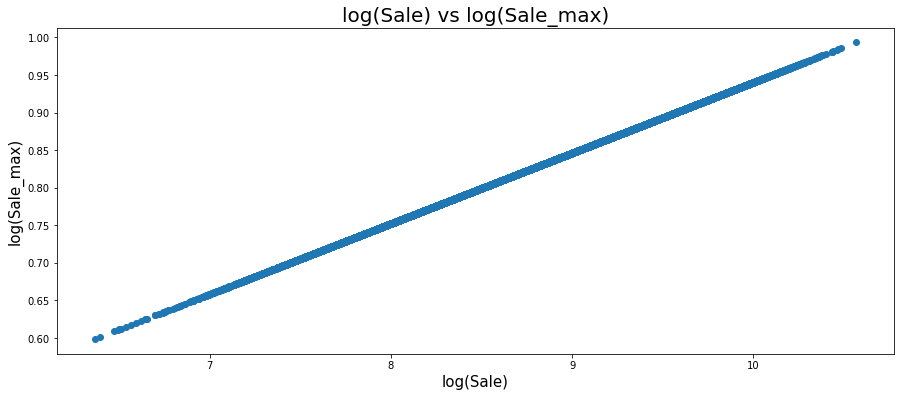

In [21]:
#plot the log(Sale) vs log(Sale_max) and see how it varies

plt.figure(figsize=(15, 6))
plt.scatter(np.log(y_train), fitting_y)
plt.title("log(Sale) vs log(Sale_max)", fontsize=20)
plt.xlabel("log(Sale)", fontsize=15)
plt.ylabel("log(Sale_max)", fontsize=15)

In [22]:
# create a checkpoint for saving model weights
model_checkpointer = ModelCheckpoint(filepath="models/nn_weights1.hdf5", verbose=1)
# compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')
# fit the model on a training set
model.fit(X_train, fitting_y, epochs=10, batch_size=128, callbacks=[model_checkpointer])

Epoch 1/10
1563/1563 [==============================] - 19s 11ms/step - loss: 0.0190

Epoch 00001: saving model to models/nn_weights1.hdf5
Epoch 2/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0083

Epoch 00002: saving model to models/nn_weights1.hdf5
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0071

Epoch 00003: saving model to models/nn_weights1.hdf5
Epoch 4/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.0065

Epoch 00004: saving model to models/nn_weights1.hdf5
Epoch 5/10
1563/1563 [==============================] - 23s 14ms/step - loss: 0.0059

Epoch 00005: saving model to models/nn_weights1.hdf5
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0055

Epoch 00006: saving model to models/nn_weights1.hdf5
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0051

Epoch 00007: saving model to models/nn_weights1.hdf5
Epoch 8/10
1563/1563 [=====

In [21]:
# load the saved weights
model.load_weights("nn_weights1.hdf5")

In [23]:
# scale y_val same as y_train
fitting_yval = np.log(y_val) / max_log_y

# predict 
y_pred_train = model.predict(X_train).flatten()
y_pred_val = model.predict(X_val).flatten()

# calculate MAPEs
mlp_train_mape = MAPE(fitting_y, y_pred_train)
mlp_val_mape = MAPE(fitting_yval, y_pred_val)

print("Training MAPE: {}\nValidation MAPE: {}".format(mlp_train_mape, mlp_val_mape))

Training MAPE: 0.004839119720150519
Validation MAPE: 0.012262920754159952


# You are done with Part 2!!
Print out the MAPE values for all models, you will need this in hand while working on Part 3 for comparing!

In [25]:
rf_mape = rf_val_mape
xg_boost_mape = xgb_val_mape
nn_mape = mlp_val_mape

mapes = {'MAPE': {'Random Forest': rf_mape, 'XGBoost': xg_boost_mape, 'Neural Network': nn_mape}}
table = pd.DataFrame(mapes)
table.reset_index(inplace=True)
table.rename(columns={'index': 'method'}, inplace=True)
table

,method,MAPE
0,Neural Network,0.012263
1,Random Forest,0.026257
2,XGBoost,0.042468
